In [166]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output 
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('train.csv')

# Set the random seed
np.random.seed(6708)

# Sample 100,000 rows
df = df.sample(n=100000)

In [167]:
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
548214,id2112935,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,-73.99,40.74,-73.99,40.73,N,494
243720,id1952188,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,-73.98,40.75,-73.99,40.76,N,445
1118153,id3658192,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,-74.00,40.75,-73.98,40.78,N,355
950698,id0845898,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,-73.97,40.80,-73.94,40.80,N,932
678061,id2813233,2,2016-04-30 23:09:43,2016-04-30 23:14:19,3,-74.00,40.67,-73.99,40.67,N,276


In [168]:
# Generate summary statistics for the existing DataFrame "df"
df.describe()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00,100000.00
mean,1.54,1.66,-73.97,40.75,-73.97,40.75,951.60
std,0.50,1.31,0.16,0.03,0.16,0.03,3197.40
min,1.00,0.00,-121.93,37.39,-121.93,37.39,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,394.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1071.00
max,2.00,7.00,-65.90,41.12,-65.90,41.42,86362.00


In [169]:
# Check the data types of the features in the existing DataFrame "df"
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [170]:
# Check for missing data
df = df.dropna()

In [171]:
missing_data = df.isnull().sum()
print("Missing data counts:")
print(missing_data)

Missing data counts:
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


In [172]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
548214,id2112935,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,-73.99,40.74,-73.99,40.73,N,494
243720,id1952188,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,-73.98,40.75,-73.99,40.76,N,445
1118153,id3658192,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,-74.00,40.75,-73.98,40.78,N,355
950698,id0845898,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,-73.97,40.80,-73.94,40.80,N,932
678061,id2813233,2,2016-04-30 23:09:43,2016-04-30 23:14:19,3,-74.00,40.67,-73.99,40.67,N,276


In [173]:
# Filter out rows with negative trip durations
df = df[df['trip_duration'] >= 0]


In [174]:
# Defining acceptable bounds for latitude and longitude
latitude_range = (40.0, 45.0)
longitude_range = (-75, -70.0)

df = df[df['pickup_latitude'].between(*latitude_range) &
          df['pickup_longitude'].between(*longitude_range) &
          df['dropoff_latitude'].between(*latitude_range) &
          df['dropoff_longitude'].between(*longitude_range)]


In [175]:
import datetime as dt
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
#assigning new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.


In [176]:
df['weekday'] = df['pickup_datetime'].dt.strftime('%A')
df['month'] = df.pickup_datetime.dt.month
df['weekday_num'] = df.pickup_datetime.dt.weekday
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [177]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,weekday,month,weekday_num,pickup_hour
548214,id2112935,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,-73.99,40.74,-73.99,40.73,N,494,Friday,1,4,15
243720,id1952188,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,-73.98,40.75,-73.99,40.76,N,445,Tuesday,5,1,16
1118153,id3658192,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,-74.00,40.75,-73.98,40.78,N,355,Friday,1,4,11
950698,id0845898,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,-73.97,40.80,-73.94,40.80,N,932,Sunday,3,6,16
678061,id2813233,2,2016-04-30 23:09:43,2016-04-30 23:14:19,3,-74.00,40.67,-73.99,40.67,N,276,Saturday,4,5,23


In [178]:
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
weekday                       object
month                          int32
weekday_num                    int32
pickup_hour                    int32
dtype: object

In [179]:
df.value_counts()

id         vendor_id  pickup_datetime      dropoff_datetime     passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  store_and_fwd_flag  trip_duration  weekday   month  weekday_num  pickup_hour
id0000001  2          2016-06-14 10:43:10  2016-06-14 11:01:35  1                -74.01            40.71            -73.97             40.75             N                   1105           Tuesday   6      1            10             1
id2661279  1          2016-03-03 22:22:14  2016-03-03 22:49:38  1                -73.87            40.77            -74.00             40.72             N                   1644           Thursday  3      3            22             1
id2662355  2          2016-01-29 21:22:22  2016-01-29 21:35:47  1                -74.00            40.74            -73.97             40.75             N                   805            Friday    1      4            21             1
id2662326  2          2016-04-05 18:04:46  2016-04-05 18:41:15  1

In [180]:
# Creating dummy variables for fuel_type
dummy_store_and_fwd_flag = pd.get_dummies(df['store_and_fwd_flag'], prefix='store_and_fwd_flag')

# Droping the first level of dummy variable
dummy_store_and_fwd_flag = dummy_store_and_fwd_flag.iloc[:, 1:]

# Replacing the original 'fuel_type' column with the dummy variables
df = pd.concat([df, dummy_store_and_fwd_flag], axis=1)

# Droping the original 'fuel_type' column
df = df.drop(columns='store_and_fwd_flag')

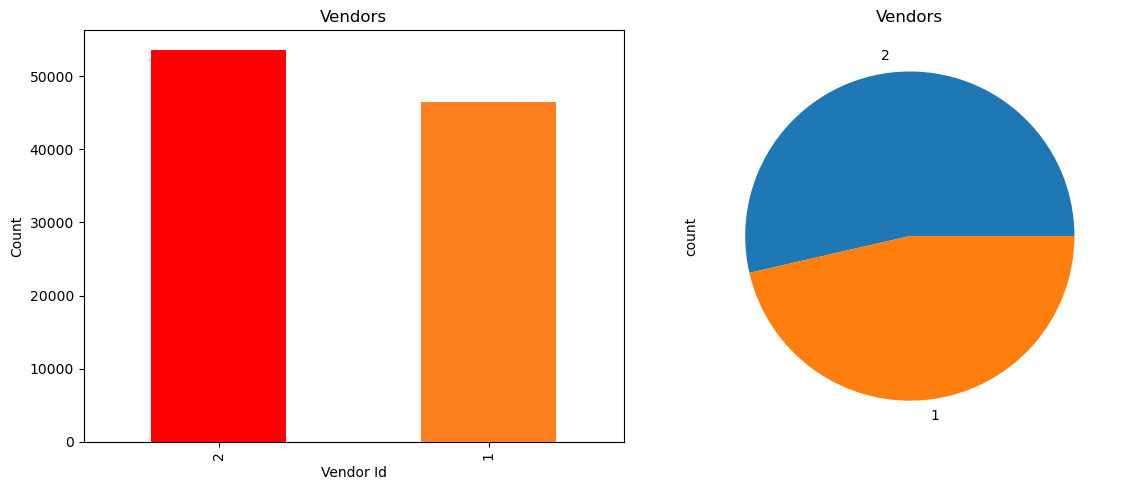

In [181]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = df['vendor_id'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('red',(1, 0.5, 0.13)))
df['vendor_id'].value_counts().plot(kind='pie',title="Vendors")
ax.set_ylabel("Count")
ax.set_xlabel("Vendor Id")
fig.tight_layout()

In [182]:
# Seting the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

# Counting the values in the 'passenger_count' column
passenger_count_counts = df['passenger_count'].value_counts()

# Displaying the counts
print(passenger_count_counts)

passenger_count
1    70891
2    14477
5     5285
3     4113
6     3307
4     1923
0        1
7        1
Name: count, dtype: int64


In [183]:
# Filtering the DataFrame to exclude rows with 0, 6, and 7 passengers
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 6)]

In [184]:
# Seting the display format for floating-point numbers
pd.options.display.float_format = '{:.2f}'.format

# Counting the values in the 'passenger_count' column
passenger_count_counts = df['passenger_count'].value_counts()

# Displaying the counts after removing outliers
print("After removing outliers from -", passenger_count_counts)

After removing outliers from - passenger_count
1    70891
2    14477
5     5285
3     4113
4     1923
Name: count, dtype: int64


/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

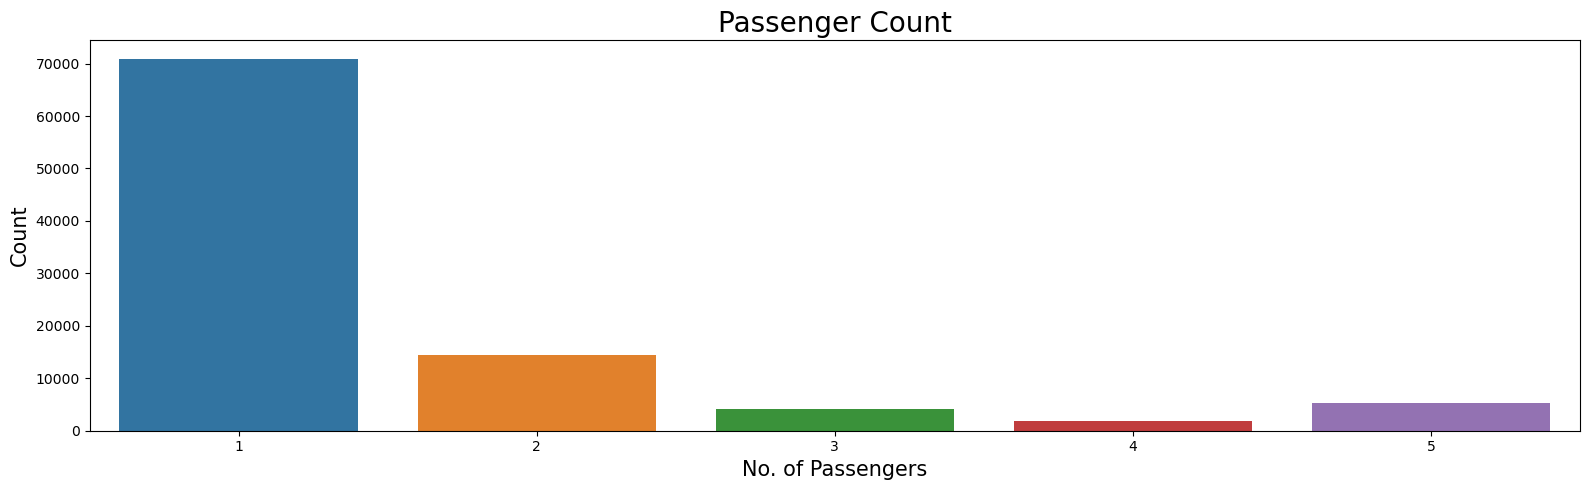

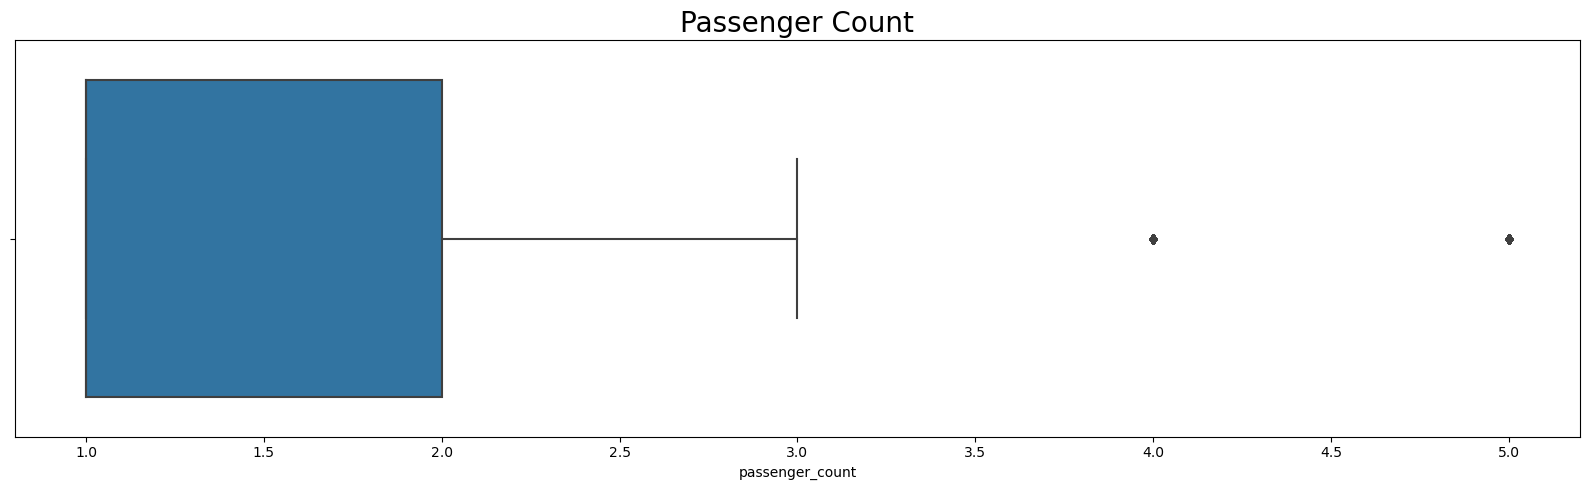

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar plot for passenger count
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
bar = sns.countplot(data=df, x='passenger_count')
bar.set_ylabel("Count", fontsize=15)
bar.set_xlabel("No. of Passengers", fontsize=15)
bar.set_title('Passenger Count', fontsize=20)
fig.tight_layout()

# Box plot for passenger count
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
box = sns.boxplot(data=df, x='passenger_count', orient='h')
box.set_title('Passenger Count', fontsize=20)
fig.tight_layout()

# Show the plots
plt.show()


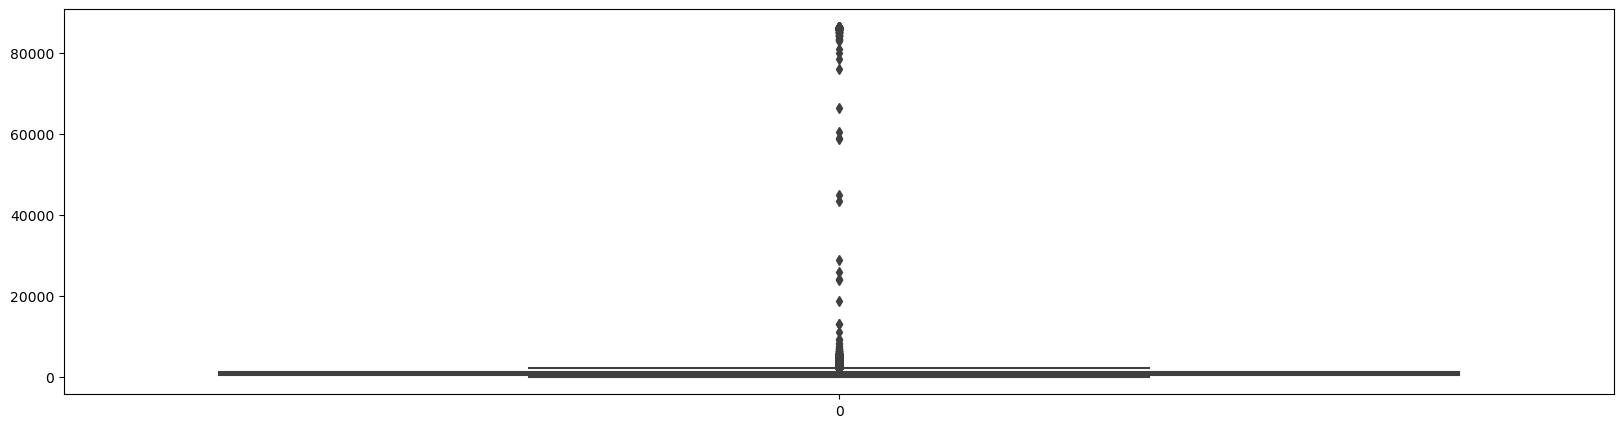

In [186]:
plt.figure(figsize = (20,5))
sns.boxplot(df.trip_duration)
plt.show()

In [187]:
# Filter out rows with negative trip durations
df = df[(df['trip_duration'] >= 0) & (df['trip_duration']<=20000)]


In [188]:
bin_edges = np.arange(0, df['trip_duration'].max(), 3600)

# Grouping and counting trips based on trip duration bins
trip_counts = df['trip_duration'].groupby(pd.cut(df['trip_duration'], bin_edges)).count()

# Printing the trip counts
print(trip_counts)

/var/folders/wz/dvpqqs715hs1594hzt3ncl540000gn/T/ipykernel_24947/2193950612.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trip_counts = df['trip_duration'].groupby(pd.cut(df['trip_duration'], bin_edges)).count()


trip_duration
(0, 3600]         95867
(3600, 7200]        675
(7200, 10800]         6
(10800, 14400]        3
(14400, 18000]        0
Name: trip_duration, dtype: int64


/var/folders/wz/dvpqqs715hs1594hzt3ncl540000gn/T/ipykernel_24947/919114996.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))


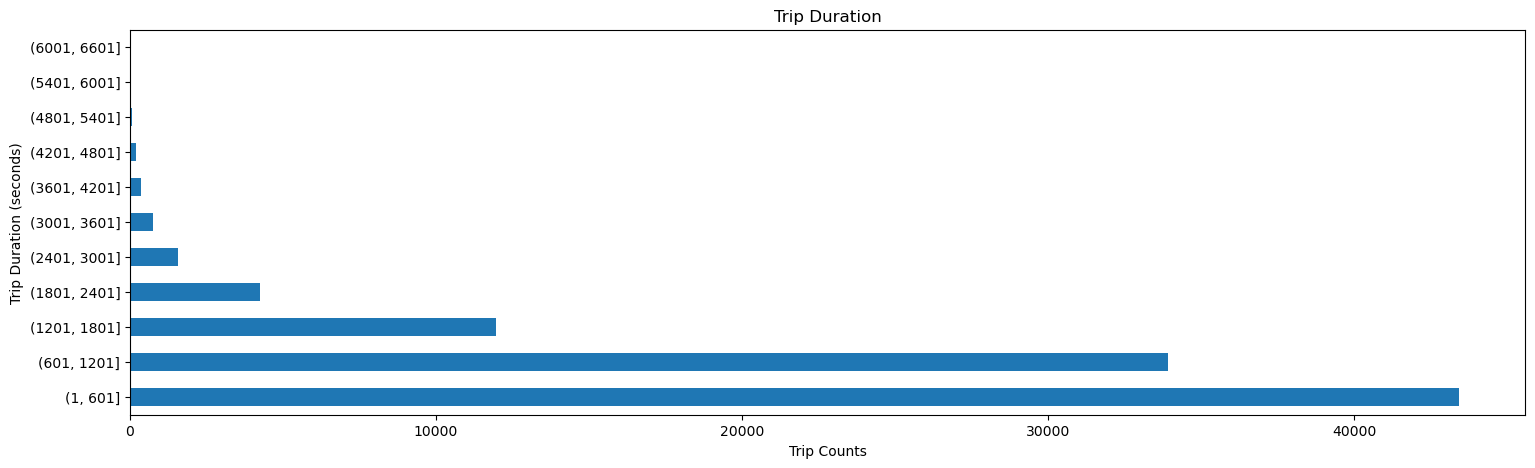

In [189]:
df.trip_duration.groupby(pd.cut(df.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh',figsize = (18,5))
plt.title('Trip Duration')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

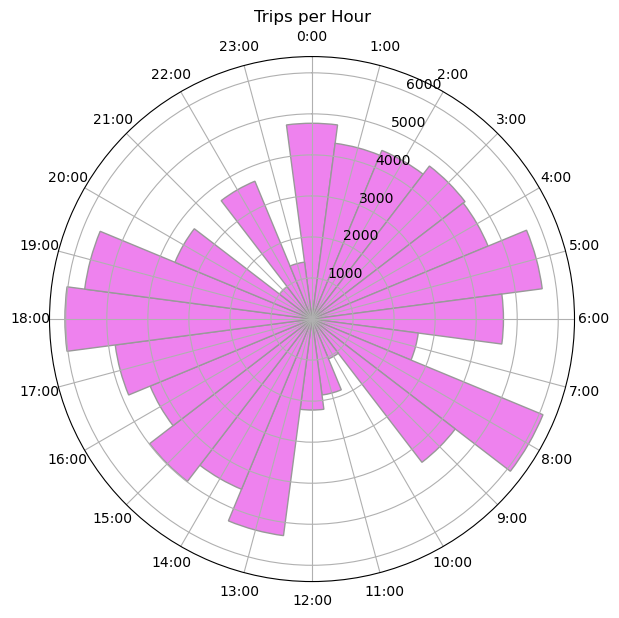

In [190]:
def clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # Create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # Width of each bin on the plot
    width = (2 * np.pi) / N

    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # Set the label to go clockwise and start from the top
    ax.set_theta_zero_location("N")
    # Set the direction to be clockwise
    ax.set_theta_direction(-1)

    # Set the labels
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

plt.figure(figsize=(15, 15))
ax = plt.subplot(2, 2, 1, polar=True)

# Calculate the number of trips per hour and convert it to an array
radii = np.array(df['pickup_hour'].value_counts(sort=False).tolist(), dtype="int64")

title = "Trips per Hour"
custom_color = 'violet'

clock(ax, radii, title, custom_color)

plt.show()



/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


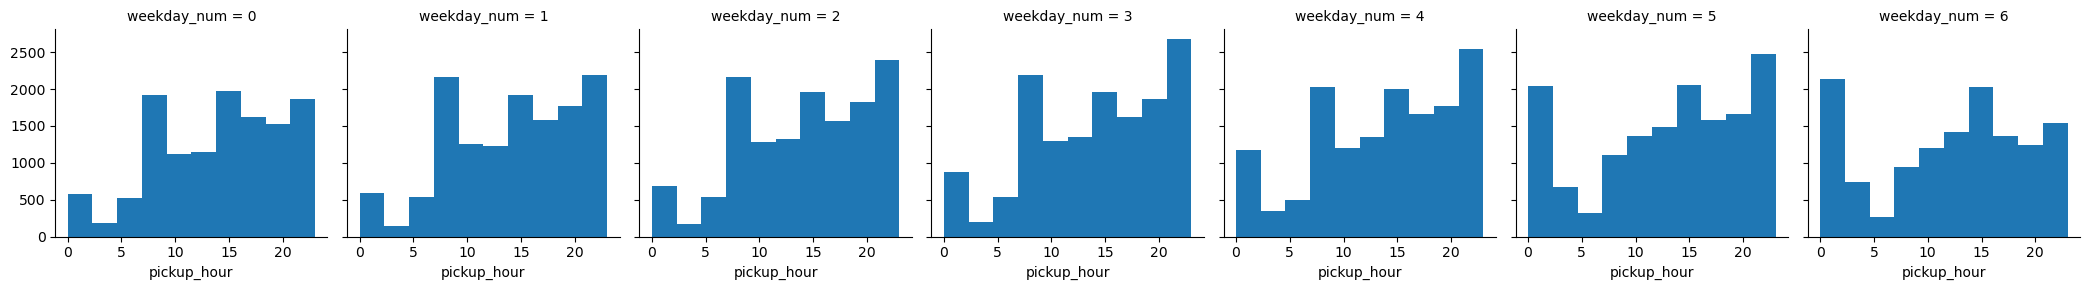

In [191]:
n = sns.FacetGrid(df, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


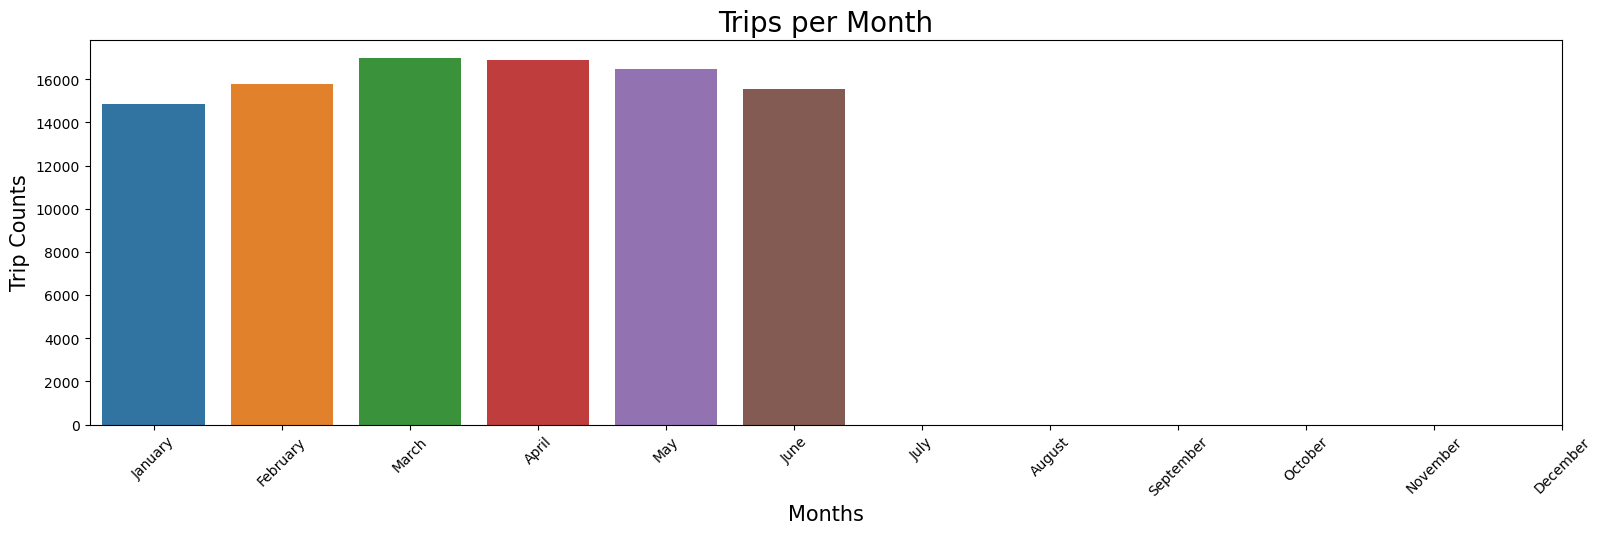

In [192]:
plt.figure(figsize=(19, 5))
count_plot = sns.countplot(data=df, x='month')
plt.ylabel('Trip Counts', fontsize=15)
plt.xlabel('Months', fontsize=15)
plt.title('Trips per Month', fontsize=20)

# Specify the positions and labels for the x-axis ticks
month_pos = list(range(12))
monthly_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

count_plot.set_xticks(month_pos)
count_plot.set_xticklabels(monthly_labels, rotation=45)

plt.show()

In [193]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [194]:
import folium
from folium.plugins import HeatMap
# Creating a map centered around the mean of pickup coordinates
pickup_heatmap = folium.Map(location=[df['pickup_latitude'].mean(), df['pickup_longitude'].mean()], zoom_start=12)
# Converting pickup locations to a list of lists for HeatMap
pickup_data = df[['pickup_latitude', 'pickup_longitude']].values.tolist()
HeatMap(pickup_data).add_to(pickup_heatmap)
pickup_heatmap.save("pickup_Geographicalmap.html")
# Creating a map centered around the mean of drop-off coordinates
dropoff_heatmap = folium.Map(location=[df['dropoff_latitude'].mean(), df['dropoff_longitude'].mean()], zoom_start=12)
# Converting drop-off locations to a list of lists for HeatMap
dropoff_data = df[['dropoff_latitude', 'dropoff_longitude']].values.tolist()
HeatMap(dropoff_data).add_to(dropoff_heatmap)
dropoff_heatmap.save("dropoff_geographicalmap.html")

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


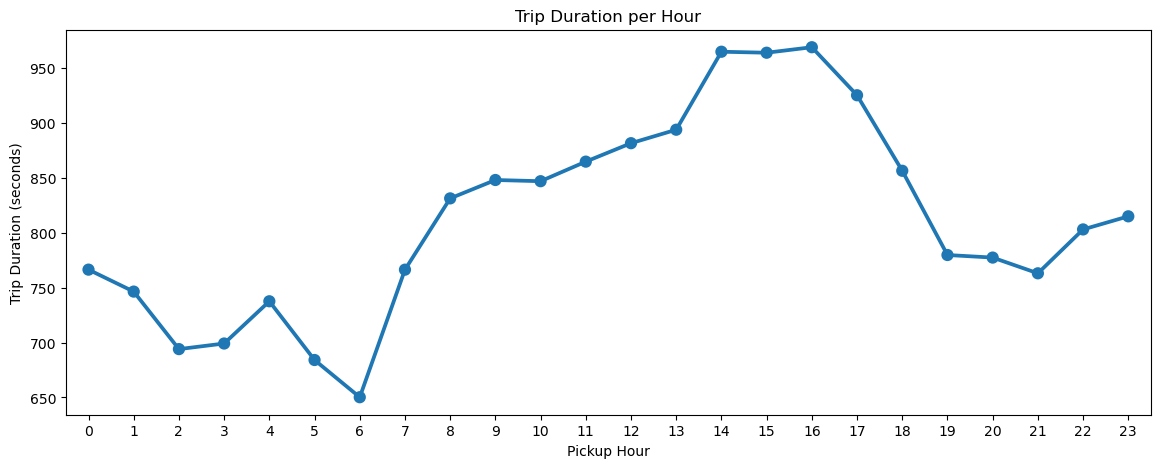

In [195]:
plt.figure(figsize=(14, 5))

# Group by pickup hour and calculate the mean trip duration
gr_1 = df.groupby('pickup_hour')['trip_duration'].mean().reset_index()

# Create a point plot
point_plot = sns.pointplot(x='pickup_hour', y='trip_duration', data=gr_1)
point_plot.set_ylabel('Trip Duration (seconds)')
point_plot.set_xlabel('Pickup Hour')
point_plot.set_title('Trip Duration per Hour')

plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


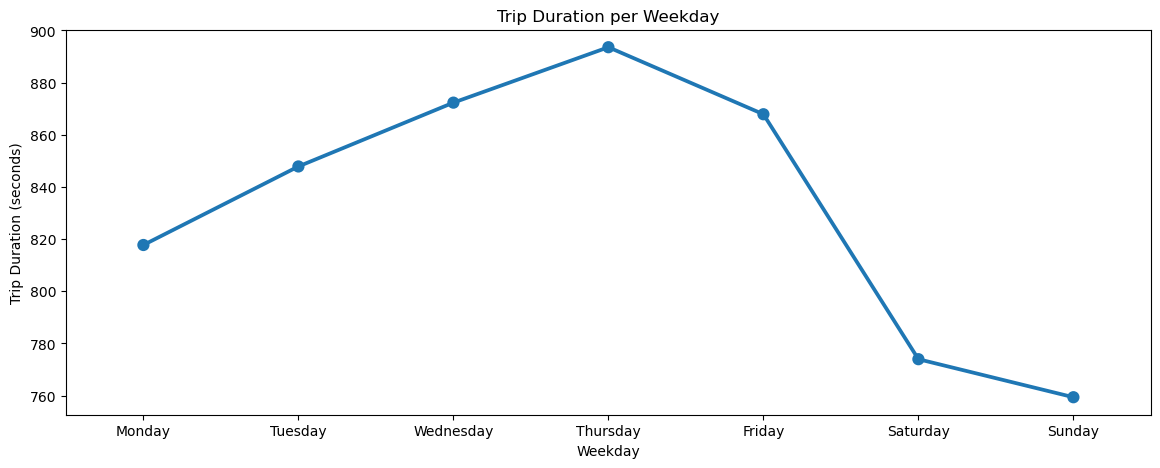

In [196]:
plt.figure(figsize=(14, 5))

# Group by weekday number and calculate the mean trip duration
gr_2 = df.groupby('weekday_num')['trip_duration'].mean().reset_index()

# Create a point plot
point_plot = sns.pointplot(x='weekday_num', y='trip_duration', data=gr_2)
point_plot.set_ylabel('Trip Duration (seconds)')
point_plot.set_xlabel('Weekday')
point_plot.set_title('Trip Duration per Weekday')

# Set x-axis labels to display the weekday names
week_day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
point_plot.set_xticklabels(week_day_labels)

plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


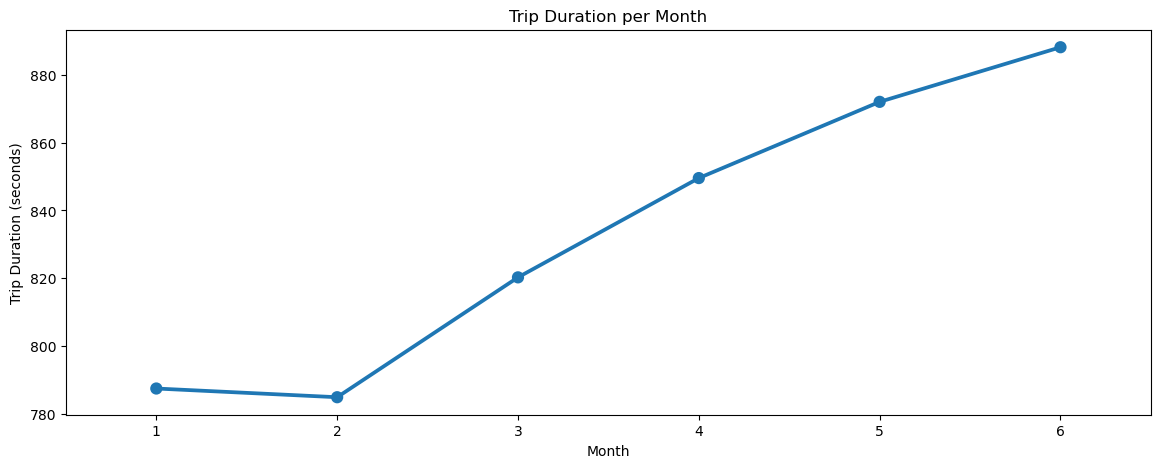

In [197]:
plt.figure(figsize=(14, 5))

# Group by month and calculate the mean trip duration
gr_3 = df.groupby('month')['trip_duration'].mean().reset_index()

# Create a point plot
point_plot = sns.pointplot(x='month', y='trip_duration', data=gr_3)
point_plot.set_ylabel('Trip Duration (seconds)')
point_plot.set_xlabel('Month')
point_plot.set_title('Trip Duration per Month')

plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


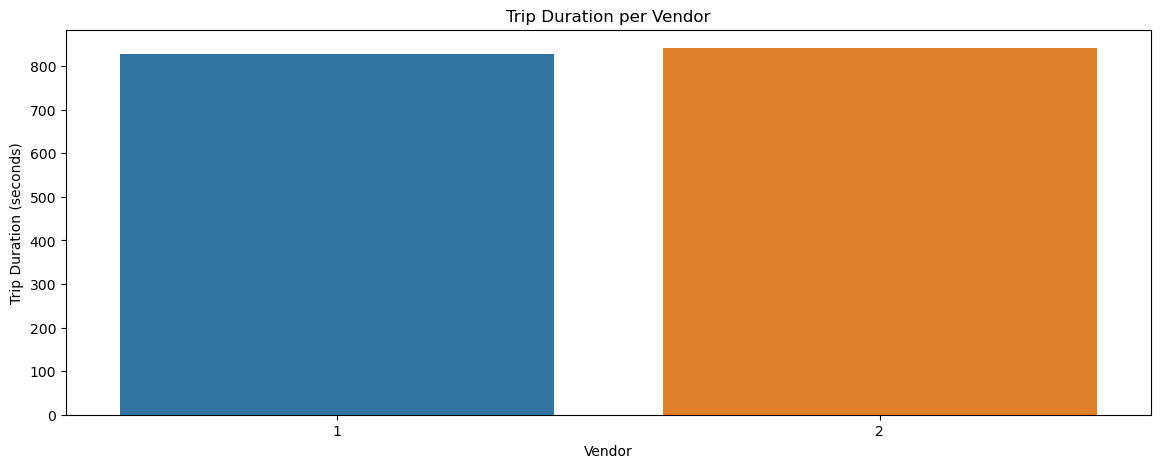

In [198]:
# Group by vendor and calculate the mean trip duration
gr_4 = df.groupby('vendor_id')['trip_duration'].mean().reset_index()

plt.figure(figsize=(14, 5))

# Create a bar plot
bar_plot = sns.barplot(x='vendor_id', y='trip_duration', data=gr_4)
bar_plot.set_ylabel('Trip Duration (seconds)')
bar_plot.set_xlabel('Vendor')
bar_plot.set_title('Trip Duration per Vendor')

plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


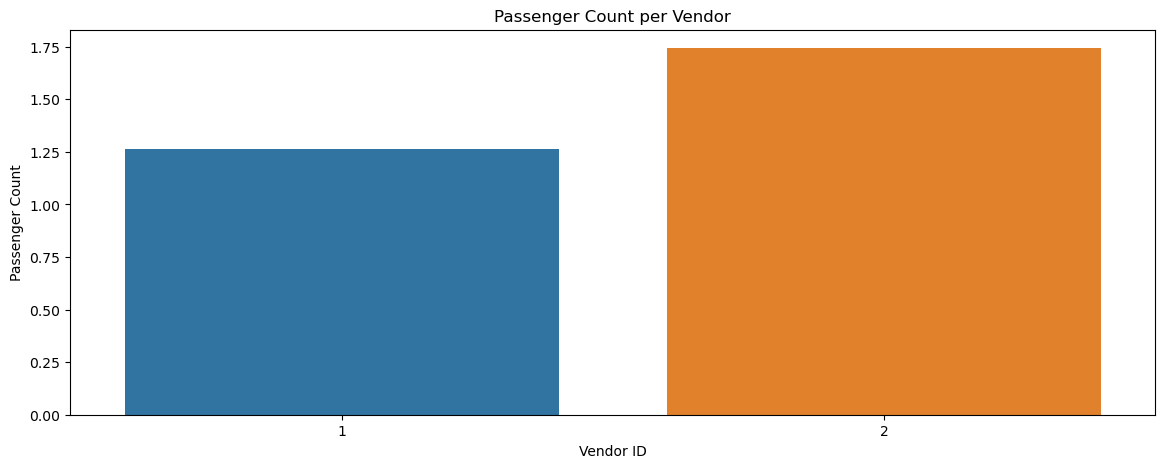

In [199]:
gr_5 = df.groupby('vendor_id')['passenger_count'].mean().reset_index()

plt.figure(figsize=(14, 5))

# Create a bar plot
bar_plot = sns.barplot(x='vendor_id', y='passenger_count', data=gr_5)
bar_plot.set_ylabel('Passenger Count')
bar_plot.set_xlabel('Vendor ID')
bar_plot.set_title('Passenger Count per Vendor')

plt.show()

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


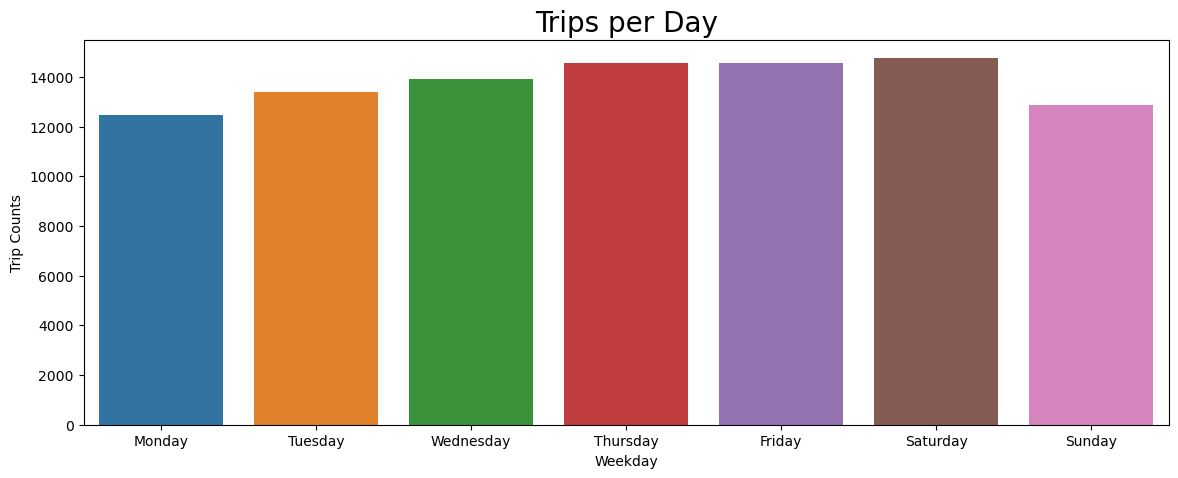

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))
trip_count_plot = sns.countplot(data=df, x='weekday_num')
plt.xlabel('Weekday')
plt.ylabel('Trip Counts')
plt.title('Trips per Day', fontsize=20)

# Set the x-axis labels to display weekdays
trip_count_plot.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.show()


In [201]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Apply label encoding to the 'vendor_id' column
df['id'] = label_encoder.fit_transform(df['id'])




In [202]:
df.dtypes

id                               int64
vendor_id                        int64
pickup_datetime         datetime64[ns]
dropoff_datetime        datetime64[ns]
passenger_count                  int64
pickup_longitude               float64
pickup_latitude                float64
dropoff_longitude              float64
dropoff_latitude               float64
trip_duration                    int64
weekday                         object
month                            int32
weekday_num                      int32
pickup_hour                      int32
store_and_fwd_flag_Y              bool
dtype: object

In [203]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,weekday,month,weekday_num,pickup_hour,store_and_fwd_flag_Y
548214,50989,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,-73.99,40.74,-73.99,40.73,494,Friday,1,4,15,False
243720,47101,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,-73.98,40.75,-73.99,40.76,445,Tuesday,5,1,16,False
1118153,88309,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,-74.00,40.75,-73.98,40.78,355,Friday,1,4,11,False
950698,20257,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,-73.97,40.80,-73.94,40.80,932,Sunday,3,6,16,False
678061,67943,2,2016-04-30 23:09:43,2016-04-30 23:14:19,3,-74.00,40.67,-73.99,40.67,276,Saturday,4,5,23,False


In [204]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Define the columns to be normalized
columns_to_normalize = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','trip_duration']

# Apply normalization to the selected columns
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


In [205]:
# Select the numerical columns for outlier detection
num_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']

# Calculate the IQR for each numerical column
Q1 = df[num_columns].quantile(0.25)
Q3 = df[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Define a factor to scale the IQR (you can adjust this factor as needed)
IQR_factor = 1.5

# Define a lower and upper bound for outlier detection
lower_bound = Q1 - IQR_factor * IQR
upper_bound = Q3 + IQR_factor * IQR

# Find rows with outliers
outliers = ((df[num_columns] < lower_bound) | (df[num_columns] > upper_bound)).any(axis=1)

# Remove rows with outliers
df_clean = df[~outliers]

df = df_clean

# Display the cleaned DataFrame
df.head()



,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,weekday,month,weekday_num,pickup_hour,store_and_fwd_flag_Y
548214,50989,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,0.49,0.63,0.47,0.46,0.03,Friday,1,4,15,False
243720,47101,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,0.50,0.64,0.47,0.48,0.02,Tuesday,5,1,16,False
1118153,88309,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,0.48,0.64,0.47,0.49,0.02,Friday,1,4,11,False
950698,20257,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,0.51,0.68,0.50,0.51,0.05,Sunday,3,6,16,False
489339,75963,2,2016-02-10 12:20:27,2016-02-10 12:37:47,1,0.49,0.61,0.46,0.46,0.06,Wednesday,2,2,12,False


In [206]:
df.shape

(82853, 15)

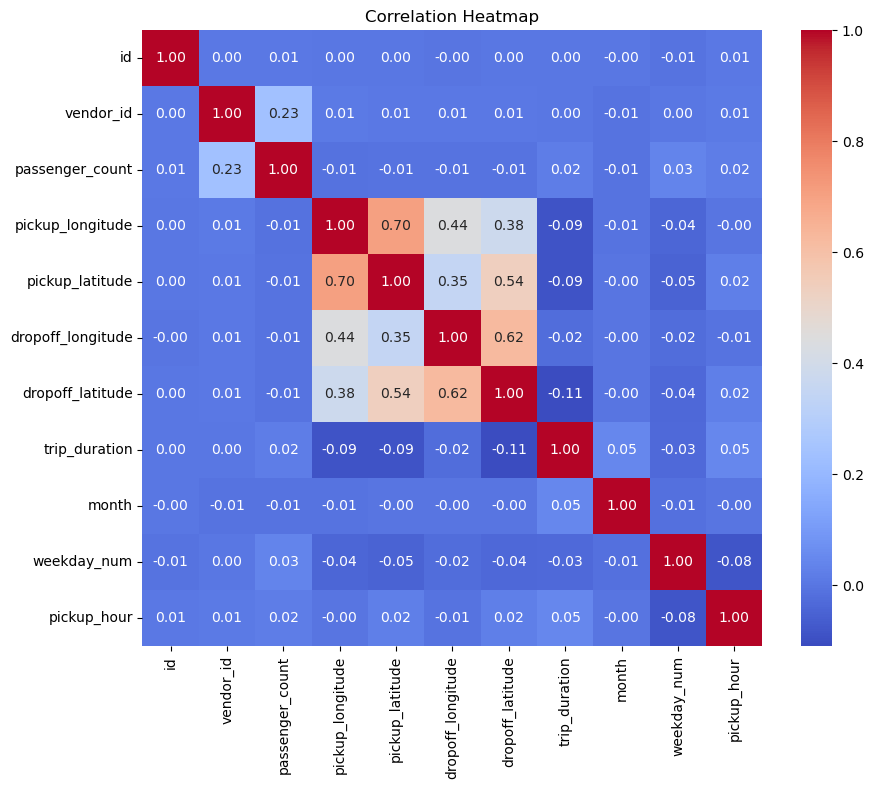

In [207]:
# Select only the numeric columns in your DataFrame
num_columns = df.select_dtypes(include=['number'])

# Calculate the correlation matrix for the numeric columns
corr_matrix = num_columns.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [208]:
# Select the predictors (independent variables) and the target (dependent variable)
predictors = ['passenger_count', 'month', 'weekday_num', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
target = 'trip_duration'
# Split the data into training and testing sets
X = df[predictors]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8765)


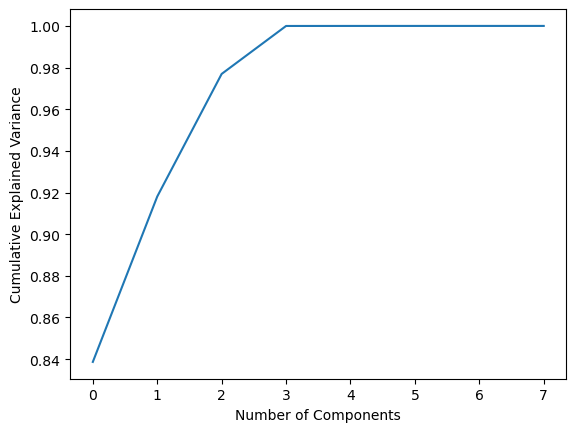

In [209]:
from sklearn.decomposition import PCA
# Fit PCA to your training data
pca = PCA().fit(X_train)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a plot to visualize the cumulative explained variance
plt.plot(cumulative_explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# Select the predictors (independent variables) and the target (dependent variable)
predictors = ['passenger_count', 'month', 'weekday_num', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
target = 'trip_duration'

# Split the data into training and testing sets
X = df[predictors]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8765)

# Create a linear regression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the model coefficients (effect of each predictor)
coefficients = dict(zip(predictors, model.coef_))
print("Model Coefficients:")
print(coefficients)

# Print evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)


Model Coefficients:
{'passenger_count': 0.0003257400243385159, 'month': 0.0005644986175170018, 'weekday_num': -0.0003937991612607301, 'pickup_hour': 0.0001670409664216176, 'pickup_longitude': -0.16684956551708177, 'pickup_latitude': 0.008798167051330123, 'dropoff_longitude': 0.17451075955459278, 'dropoff_latitude': -0.16812825272091725}
Mean Squared Error: 0.0004553457394064483
R-squared (R2) Score: 0.026839641805014747


In [211]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 83.87),
 (2, 91.81),
 (3, 97.7),
 (4, 100.0),
 (5, 100.0),
 (6, 100.0),
 (7, 100.0)]

In [212]:
start_time = time.time()
lm_regression = LinearRegression()
lm_regression = lm_regression.fit(X_train, y_train)
end_time = time.time()
lm_time = (end_time - start_time)
print(f"Time taken to train linear regression model : {lm_time} seconds")

Time taken to train linear regression model : 0.022589921951293945 seconds


In [213]:
trips = lm_regression.predict(X_test)

In [214]:
lm_score = r2_score(y_test, trips)
print(lm_score)

0.026839641805014747


In [215]:
start_time = time.time()
rf_regression = RandomForestRegressor()
rf_regression = rf_regression.fit(X_train, y_train)
end_time = time.time()
rf_time = (end_time - start_time)
print(f"Time taken to train Random Forest model : {rf_time} seconds")

Time taken to train Random Forest model : 32.68100380897522 seconds


In [216]:
rf_score = r2_score(y_test, trips)
print("random forest r2 score", rf_score)

random forest r2 score 0.026839641805014747


In [217]:
from sklearn.tree import DecisionTreeRegressor

# Create and fit the Decision Tree regression model, measuring the time
start_time = time.time()
dt_regression = DecisionTreeRegressor().fit(X_train, y_train)
end_time = time.time()
dt_time = end_time - start_time

print(f"Time to train Decision Tree model: {dt_time:.2f} seconds")

# Predict on the test data
trips = dt_regression.predict(X_test)

Time to train Decision Tree model: 0.51 seconds


In [218]:
de_t_score = r2_score(y_test, trips)
print("Decision tree r2 score", de_t_score)

Decision tree r2 score 0.33673229969968743


In [219]:
from sortedcontainers import SortedDict

# Initialize a SortedDict to store trip data sorted by trip duration
trip_sorted_data = SortedDict()

# Populate the SortedDict with the data from the DataFrame
for index, row in df.iterrows():
    trip_id = row['id']
    trip_duration = row['trip_duration']
    trip_sorted_data[trip_duration] = (trip_id, row)

# Adding a new trip (as an example)
new_trip_id = 'new_trip_id'
new_trip_duration = 500  
new_trip_data = {
    'vendor_id': 'new_vendor',
    'pickup_datetime': '2023-10-28 10:00:00',
    'dropoff_datetime': '2023-10-28 10:30:00',
    'passenger_count': 3,
    'pickup_longitude': -73.9895,
    'pickup_latitude': 40.7523,
    'dropoff_longitude': -73.9876,
    'dropoff_latitude': 40.7612,
    'store_and_fwd_flag': 'N',
}
trip_sorted_data[new_trip_duration] = (new_trip_id, new_trip_data)

# View the data in ascending order of trip duration with formatted durations
for duration, (trip_id, data) in trip_sorted_data.items():
    formatted_duration = f"{duration:.2f}"  # Format the duration with 2 decimal places
    print(f"Trip ID: {trip_id}, Duration: {formatted_duration} seconds")



Trip ID: 11420, Duration: 0.00 seconds
Trip ID: 44577, Duration: 0.00 seconds
Trip ID: 64824, Duration: 0.00 seconds
Trip ID: 85255, Duration: 0.00 seconds
Trip ID: 56691, Duration: 0.00 seconds
Trip ID: 49499, Duration: 0.00 seconds
Trip ID: 49074, Duration: 0.00 seconds
Trip ID: 38987, Duration: 0.00 seconds
Trip ID: 72799, Duration: 0.00 seconds
Trip ID: 17063, Duration: 0.00 seconds
Trip ID: 14877, Duration: 0.00 seconds
Trip ID: 71215, Duration: 0.00 seconds
Trip ID: 18944, Duration: 0.00 seconds
Trip ID: 21911, Duration: 0.00 seconds
Trip ID: 28862, Duration: 0.00 seconds
Trip ID: 68045, Duration: 0.00 seconds
Trip ID: 61455, Duration: 0.00 seconds
Trip ID: 41332, Duration: 0.00 seconds
Trip ID: 94460, Duration: 0.00 seconds
Trip ID: 84747, Duration: 0.00 seconds
Trip ID: 87096, Duration: 0.00 seconds
Trip ID: 3140, Duration: 0.00 seconds
Trip ID: 12586, Duration: 0.00 seconds
Trip ID: 91409, Duration: 0.00 seconds
Trip ID: 48010, Duration: 0.00 seconds
Trip ID: 44593, Duration: 

In [220]:
trip_durations = df['trip_duration'].values  # Extracting trip durations as a NumPy array

# Sorting the trip durations in ascending order
sorted_trip_durations = sorted(trip_durations)

# Convert the sorted array back to a DataFrame if needed
sorted_df = pd.DataFrame({'trip_duration': sorted_trip_durations})

# Display the sorted DataFrame
print(sorted_df)

       trip_duration
0               0.00
1               0.00
2               0.00
3               0.00
4               0.00
...              ...
82848           0.11
82849           0.11
82850           0.11
82851           0.11
82852           0.11

[82853 rows x 1 columns]


In [221]:
# Adding the sorted trip duration column to the original DataFrame 'df'
df['sorted_trip_duration'] = sorted_df
df

/var/folders/wz/dvpqqs715hs1594hzt3ncl540000gn/T/ipykernel_24947/1954868364.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sorted_trip_duration'] = sorted_df


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,weekday,month,weekday_num,pickup_hour,store_and_fwd_flag_Y,sorted_trip_duration
548214,50989,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,0.49,0.63,0.47,0.46,0.03,Friday,1,4,15,False,NaN
243720,47101,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,0.50,0.64,0.47,0.48,0.02,Tuesday,5,1,16,False,NaN
1118153,88309,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,0.48,0.64,0.47,0.49,0.02,Friday,1,4,11,False,NaN
950698,20257,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,0.51,0.68,0.50,0.51,0.05,Sunday,3,6,16,False,NaN
489339,75963,2,2016-02-10 12:20:27,2016-02-10 12:37:47,1,0.49,0.61,0.46,0.46,0.06,Wednesday,2,2,12,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951906,5301,2,2016-05-22 20:16:10,2016-05-22 20:23:02,1,0.51,0.68,0.49,0.50,0.02,Sunday,5,6,20,False,NaN
1072937,22654,2,2016-03-11 17:29:25,2016-03-11 17:48:06,2,0.49,0.64,0.47,0.48,0.06,Friday,3,4,17,False,NaN
1154625,51511,1,2016-01-28 18:03:36,2016-01-28 18:25:48,2,0.50,0.64,0.48,0.45,0.07,Thursday,1,3,18,False,NaN
339012,23887,1,2016-06-03 15:59:02,2016-06-03 16:04:20,1,0.50,0.67,0.47,0.50,0.02,Friday,6,4,15,False,NaN


In [222]:
pip install faker


Note: you may need to restart the kernel to use updated packages.


In [223]:
from faker import Faker

# Initialize Faker to generate random data
var_fake = Faker()

# Replace 'df' with your actual DataFrame

# Generate random phone numbers for each row in the DataFrame
phone_numbers_random = [var_fake.phone_number() for _ in range(len(df))]

# Add the 'phone_number' column to the DataFrame
df['passenger_phone_number'] = phone_numbers_random

# Display the updated DataFrame with phone numbers
print(df)

            id  vendor_id     pickup_datetime    dropoff_datetime  \
548214   50989          1 2016-01-15 15:17:28 2016-01-15 15:25:42   
243720   47101          2 2016-05-10 16:19:36 2016-05-10 16:27:01   
1118153  88309          1 2016-01-01 11:22:15 2016-01-01 11:28:10   
950698   20257          2 2016-03-06 16:43:01 2016-03-06 16:58:33   
489339   75963          2 2016-02-10 12:20:27 2016-02-10 12:37:47   
...        ...        ...                 ...                 ...   
951906    5301          2 2016-05-22 20:16:10 2016-05-22 20:23:02   
1072937  22654          2 2016-03-11 17:29:25 2016-03-11 17:48:06   
1154625  51511          1 2016-01-28 18:03:36 2016-01-28 18:25:48   
339012   23887          1 2016-06-03 15:59:02 2016-06-03 16:04:20   
700780   31774          1 2016-04-19 10:24:07 2016-04-19 10:25:07   

         passenger_count  pickup_longitude  pickup_latitude  \
548214                 1              0.49             0.63   
243720                 2              0.50   

/var/folders/wz/dvpqqs715hs1594hzt3ncl540000gn/T/ipykernel_24947/2445548937.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['passenger_phone_number'] = phone_numbers_random


In [224]:
# Geting the unique phone numbers in the DataFrame
unique_phone_numbers = df['passenger_phone_number'].unique()

chosen_phone_numbers = unique_phone_numbers[:3]

# Filtering trips for each chosen phone number
for chosen_phone_number in chosen_phone_numbers:
    filtered_trips = df[df['passenger_phone_number'] == chosen_phone_number]

    # Checking if any trips were found for the chosen phone number
    if not filtered_trips.empty:
        print(f"Trips made by passenger with phone number {chosen_phone_number}:")
        print(filtered_trips)
    else:
        print(f"No trips found for passenger with phone number {chosen_phone_number}")


Trips made by passenger with phone number (291)439-9895x5187:
           id  vendor_id     pickup_datetime    dropoff_datetime  \
548214  50989          1 2016-01-15 15:17:28 2016-01-15 15:25:42   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
548214                1              0.49             0.63               0.47   

        dropoff_latitude  trip_duration weekday  month  weekday_num  \
548214              0.46           0.03  Friday      1            4   

        pickup_hour  store_and_fwd_flag_Y  sorted_trip_duration  \
548214           15                 False                   NaN   

       passenger_phone_number  
548214     (291)439-9895x5187  
Trips made by passenger with phone number (281)398-5009:
           id  vendor_id     pickup_datetime    dropoff_datetime  \
243720  47101          2 2016-05-10 16:19:36 2016-05-10 16:27:01   

        passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
243720               

In [225]:
df.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,weekday,month,weekday_num,pickup_hour,store_and_fwd_flag_Y,sorted_trip_duration,passenger_phone_number
548214,50989,1,2016-01-15 15:17:28,2016-01-15 15:25:42,1,0.49,0.63,0.47,0.46,0.03,Friday,1,4,15,False,NaN,(291)439-9895x5187
243720,47101,2,2016-05-10 16:19:36,2016-05-10 16:27:01,2,0.50,0.64,0.47,0.48,0.02,Tuesday,5,1,16,False,NaN,(281)398-5009
1118153,88309,1,2016-01-01 11:22:15,2016-01-01 11:28:10,1,0.48,0.64,0.47,0.49,0.02,Friday,1,4,11,False,NaN,949-957-5127x03462
950698,20257,2,2016-03-06 16:43:01,2016-03-06 16:58:33,1,0.51,0.68,0.50,0.51,0.05,Sunday,3,6,16,False,NaN,+1-645-526-1946
489339,75963,2,2016-02-10 12:20:27,2016-02-10 12:37:47,1,0.49,0.61,0.46,0.46,0.06,Wednesday,2,2,12,False,NaN,7145228239
1159895,76933,2,2016-02-12 16:33:48,2016-02-12 16:38:26,1,0.49,0.65,0.47,0.48,0.01,Friday,2,4,16,False,NaN,(313)673-8576x25289
805697,96372,2,2016-05-05 21:17:46,2016-05-05 21:35:04,1,0.50,0.65,0.47,0.46,0.06,Thursday,5,3,21,False,NaN,732-700-8859x5634
412884,81255,2,2016-03-25 01:08:03,2016-03-25 01:13:31,1,0.49,0.65,0.48,0.50,0.02,Friday,3,4,1,False,NaN,486-266-7112
217137,64425,1,2016-04-09 19:50:14,2016-04-09 20:01:54,3,0.49,0.61,0.47,0.46,0.04,Saturday,4,5,19,False,NaN,+1-796-512-3912x8674
905302,84480,1,2016-05-30 09:45:20,2016-05-30 09:55:25,1,0.50,0.63,0.47,0.48,0.03,Monday,5,0,9,True,NaN,3168365014
